In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from scipy.ndimage.filters import convolve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
"""
This produces a dataset 5 times bigger than the original one,
by moving the 8x8 images in X around by 1px to left, right, down, up
"""
def nudge_dataset(X, Y):
    direction_vectors = [
    [[0, 1, 0],
    [0, 0, 0],
    [0, 0, 0]],

    [[0, 0, 0],
    [1, 0, 0],
    [0, 0, 0]],

    [[0, 0, 0],
    [0, 0, 1],
    [0, 0, 0]],

    [[0, 0, 0],
    [0, 0, 0],
    [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((64, 64)), mode='constant', weights=w).ravel()
    X = np.concatenate([X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [3]:
olivetti = fetch_olivetti_faces()
X, Y = olivetti.data, olivetti.target

Rescaling

In [4]:
X = np.asarray( X, 'float32')
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

We nudge the faces of 8×8 pixel patches and convolute. This produces 5 times the data. This means after this process our data size will be 400×5 = 2000 rows.

In [5]:
X, Y = nudge_dataset(X, Y)

Convert image array to binary with threshold 

In [6]:
X = X > 0.5

In [7]:
X.shape

(2000, 4096)

In [8]:
images = olivetti.images

In [9]:
images.shape

(400, 64, 64)

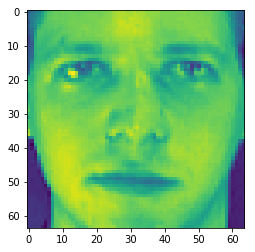

In [10]:
plt.imshow(images[0])

In [11]:
logistic = LogisticRegression(C=10)
rbm = BernoulliRBM(n_components=180, learning_rate=0.01, batch_size=10, n_iter=50, verbose=True, random_state=None)
clf = Pipeline(steps=[('rbm', rbm), ('clf', logistic)])
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)
clf.fit(X_train,Y_train) 
Y_pred = clf.predict(X_test)
print ('Score:  ',(classification_report(Y_test, Y_pred)))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2233.37, time = 1.51s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2016.70, time = 1.60s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1896.40, time = 1.62s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1774.27, time = 1.61s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1766.36, time = 1.57s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1893.72, time = 1.60s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1778.07, time = 1.59s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1693.05, time = 1.62s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1713.74, time = 1.61s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -1632.72, time = 1.60s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -1582.28, time = 1.61s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -1543.42, time = 1.61s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -1463.33, time = 1.64s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -1499.95, time = 1.77s
[

Now we plot the RBM components of first 16 faces

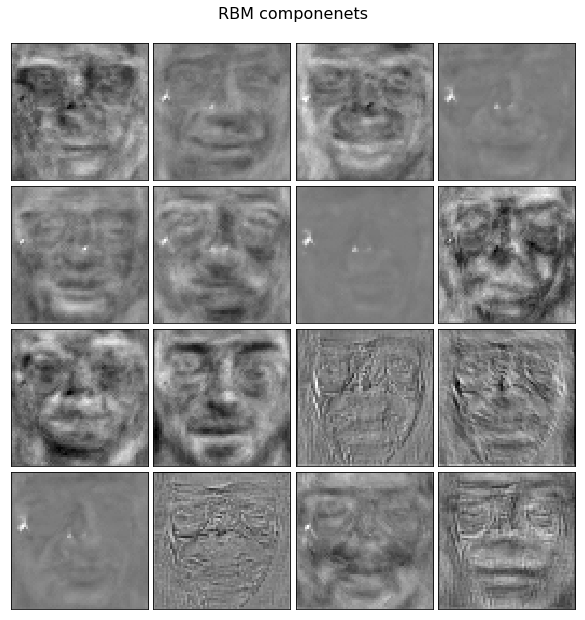

In [29]:
comp = rbm.components_
image_shape = (64, 64)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('RBM componenets', comp[:16], 4,4)